# EEGDash example for sex classification

The code below provides an example of using the *EEGDash* library in combination with PyTorch to develop a deep learning model for detecting sex in a collection of 136 subjects.

1. **Data Retrieval Using EEGDash**: An instance of *EEGDashDataset* is created to search and retrieve resting state data for 136 subjects (dataset ds005505). At this step, only the metadata is transferred.

2. **Data Preprocessing Using BrainDecode**: This process preprocesses EEG data using Braindecode by selecting specific channels, resampling, filtering, and extracting 2-second epochs. This takes about 2 minutes.

3. **Creating a train and testing sets**: The dataset is split into training (80%) and testing (20%) sets with balanced labels--making sure also that we have as many males as females--converted into PyTorch tensors, and wrapped in DataLoader objects for efficient mini-batch training.

4. **Model Definition**: The model is a custom convolutional neural network with 24 input channels (EEG channels), 2 output classes (male and female).

5. **Model Training and Evaluation Process**: This section trains the neural network, normalizes input data, computes cross-entropy loss, updates model parameters, and evaluates classification accuracy over six epochs. This takes less than 10 seconds to a couple of minutes, depending on the device you use.



## Data Retrieval Using EEGDash

First we find one resting state dataset for a collection of subject. The dataset ds005505 contains 136 subjects with both male and female participants.

In [1]:

# from eegdash import EEGDashDataset

# ds_sexdata = EEGDashDataset({'dataset': 'ds005505', 'task': 'RestingState'}, target_name='sex')

## Data Preprocessing Using Braindecode

[BrainDecode](https://braindecode.org/stable/install/install.html) is a specialized library for preprocessing EEG and MEG data. 

We apply three preprocessing steps in Braindecode:
1.	**Selection** of 24 specific EEG channels from the original 128.
2.	**Resampling** the EEG data to a frequency of 128 Hz.
3.	**Filtering** the EEG signals to retain frequencies between 1 Hz and 55 Hz.

When calling the **preprocess** function, the data is retrieved from the remote repository.

Finally, we use **create_windows_from_events** to extract 2-second epochs from the data. These epochs serve as the dataset samples.

In [2]:
# from braindecode.preprocessing import (preprocess, Preprocessor, create_fixed_length_windows)
# import os

# # Alternatively, if you want to include this as a preprocessing step in a Braindecode pipeline:
# preprocessors = [
#     Preprocessor('pick_channels', ch_names=['E22', 'E9', 'E33', 'E24', 'E11', 'E124', 'E122', 'E29', 'E6', 'E111', 'E45', 'E36', 'E104', 'E108', 'E42', 'E55', 'E93', 'E58', 'E52', 'E62', 'E92', 'E96', 'E70', 'Cz']),
#     Preprocessor("resample", sfreq=128),
#     Preprocessor("filter", l_freq=1, h_freq=55)
# ]
# preprocess(ds_sexdata, preprocessors, n_jobs=-1) #, save_dir='xxxx'' will save and set preload to false

# # extract windows and save to disk
# windows_ds = create_fixed_length_windows(ds_sexdata, start_offset_samples=0, stop_offset_samples=None,
#         window_size_samples=256, window_stride_samples=256, drop_last_window=True, preload=False) 
# os.makedirs('data/hbn_preprocessed_restingstate', exist_ok=True)
# windows_ds.save('data/hbn_preprocessed_restingstate', overwrite=True)

## Plotting a Single Channel for One Sample

It’s always a good practice to verify that the data has been properly loaded and processed. Here, we plot a single channel from one sample to ensure the signal is present and looks as expected.

In [3]:
# import matplotlib.pyplot as plt
# plt.figure()
# plt.plot(windows_ds[1000][0][0,:].transpose()) # first channel of first epoch
# plt.show()

## Load pre-saved data

If you have run the previous steps before, the data should be saved and may be reloaded here. If you are simply running this notebook for the first time, there is no need to reload the data, and this step may be skipped. However, it is quick, so you might as well execute the cell; it will have no consequences and will allow you to check that the data was saved properly.

In [4]:
from braindecode.datautil import load_concat_dataset

print("Loading data from disk")
windows_ds = load_concat_dataset(path='data/hbn_preprocessed_restingstate', preload=False)


Loading data from disk


## Feature Extraction

In [5]:
from eegdash import features
from eegdash.features import extract_features, fit_feature_extractors
from functools import partial

sfreq = windows_ds.datasets[0].raw.info['sfreq']
filter_freqs = dict(windows_ds.datasets[0].raw_preproc_kwargs)['filter']
features_dict = {
    "sig": features.ByChannelFeatureExtractor(
        {
            "mean": features.signal_mean,
            "var": features.signal_variance,
            "std": features.signal_std,
            "skew": features.signal_skewness,
            "kurt": features.signal_kurtosis,
            "rms": features.signal_root_mean_square,
            "ptp": features.signal_peak_to_peak,
            "quan.1": partial(features.signal_quantile, q=0.1),
            "quan.9": partial(features.signal_quantile, q=0.9),
            "line_len": features.signal_line_length,
            "zero_x": features.signal_zero_crossings,
            "hjorth": features.HjorthFeatureExtractor(
                {
                    "mob": features.signal_hjorth_mobility,
                    "comp": features.signal_hjorth_complexity,
                },
            ),
            "dcorr_t": partial(features.signal_decorrelation_time, fs=sfreq),
        },
    ),
    "dim": features.ByChannelFeatureExtractor(
        {
            "higuchi": partial(features.dimensionality_higuchi_fractal_dim, k_max=5),
            "katz": partial(features.dimensionality_katz_fractal_dim),
            "pet": features.dimensionality_petrosian_fractal_dim,
            "hurst": features.dimensionality_hurst_exp,
            "dfa": features.dimensionality_detrended_fluctuation_analysis,
        },
    ),
    "comp": features.ByChannelFeatureExtractor(
        {
            "ent": features.EntropyFeatureExtractor(
                {
                    "app": features.complexity_approx_entropy,
                    "samp": features.complexity_sample_entropy,
                },
                m=2, r=0.2, l=1,
            ),
            "ent_svd": partial(features.complexity_svd_entropy, m=20),
            "lzc": features.complexity_lempel_ziv,
        },
    ),
    "spec": features.SpectralFeatureExtractor(
        {
            "rtot_power": features.spectral_root_total_power,
            "band_power": features.spectral_bands_power,
            "hjorth_act": features.spectral_hjorth_activity,
            0: features.NormalizedSpectralFeatureExtractor(
                {
                    "moment": features.spectral_moment,
                    "entropy": features.spectral_entropy,
                    "edge": partial(features.spectral_edge, edge=0.9),
                    "hjorth_mob": features.spectral_hjorth_mobility,
                    "hjorth_comp": features.spectral_hjorth_complexity,
                },
            ),
            1: features.DBSpectralFeatureExtractor(
                {
                    "slope": features.spectral_slope,
                },
            ),
        },
        fs=sfreq,
        f_min=filter_freqs['l_freq'],
        f_max=filter_freqs['h_freq'],
    ),
    "coher": features.CoherenceFeatureExtractor(
        {
            "msc": features.connectivity_magnitude_square_coherence,
        },
        fs=sfreq,
        f_min=filter_freqs['l_freq'],
        f_max=filter_freqs['h_freq'],
    ),
    "csp": partial(features.CommonSpatialPattern(), n_select=5),
}

# TODO: fit on train, extract on train/validation
feature_ext = fit_feature_extractors(windows_ds, features_dict, batch_size=8192)
features_ds = extract_features(windows_ds, feature_ext, batch_size=512, n_jobs=-1)

Extracting features: 100%|██████████| 136/136 [05:32<00:00,  2.45s/it] 


In [6]:
import os

os.makedirs('data/hbn_features_restingstate', exist_ok=True)
features_ds.save('data/hbn_features_restingstate', overwrite=True)

In [7]:
from eegdash.features import load_features_concat_dataset

print("Loading features from disk")
features_ds = load_features_concat_dataset(path='data/hbn_features_restingstate', n_jobs=-1)

Loading features from disk


In [8]:
features_ds.to_dataframe()

sig_mean_E22   sig_mean_E9  sig_mean_E33  sig_mean_E24  sig_mean_E11  \
0      3.582612e-06  6.440708e-07  1.268285e-06  1.891014e-06  1.481561e-06   
1     -1.890628e-06 -1.760205e-06  1.520069e-06  8.348851e-07  3.492121e-07   
2     -5.983285e-07 -7.747178e-07 -7.765483e-07 -4.119730e-07 -2.536662e-07   
3      2.015448e-06  2.057481e-06 -2.804825e-09  3.264633e-07  5.674021e-07   
4     -5.447459e-06 -2.413422e-06 -9.679432e-07 -1.073142e-06 -9.542446e-07   
...             ...           ...           ...           ...           ...   
28787  3.097745e-06  1.597780e-06  2.376110e-06  2.363819e-06  2.906632e-06   
28788 -1.127522e-06 -4.337861e-07 -9.567456e-07 -3.261324e-07 -6.375282e-07   
28789 -2.205115e-07  2.032506e-07 -2.105074e-07 -2.046381e-07  8.584857e-08   
28790  2.420226e-06 -9.451001e-07  2.375491e-06  1.741610e-06  9.850377e-07   
28791  1.482803e-05  1.344087e-05  6.131188e-06  3.963781e-06  7.468629e-06   

       sig_mean_E124  sig_mean_E122  sig_mean_E29   sig_mean_E6  \
0      -1.535326e-07  -1.966901e-07  1.767885e-06  5.952882e-07   
1       4.868210e-07   9.306350e-07  7.085728e-07  2.929870e-07   
2      -7.639537e-07  -1.012894e-06 -4.283622e-07 -1.504008e-07   
3       1.042493e-06   9.974118e-07  3.528527e-07  1.395176e-07   
4      -2.437479e-07   1.017557e-07 -6.487876e-07 -1.616251e-07   
...              ...            ...           ...           ...   
28787   1.518742e-06   8.456714e-07  1.741083e-06  1.884639e-06   
28788   6.409522e-09   3.363403e-07 -1.631429e-07 -3.550955e-07   
28789   6.120729e-09  -2.059947e-07 -1.223173e-07 -7.693704e-08   
28790  -9.878183e-07  -1.354862e-06  8.727765e-07  2.274077e-07   
28791   6.640563e-06   3.151092e-06 -2.500395e-06  3.472844e-06   

       sig_mean_E111  ...  coher_msc_beta_E92<>Cz  coher_msc_beta_E96<>E70  \
0       1.045822e-07  ...                     NaN                      1.0   
1       5.572061e-07  ...                     NaN                      1.0   
2      -6.294506e-07  ...                     NaN                      1.0   
3       7.633845e-07  ...                     NaN                      1.0   
4      -1.390605e-07  ...                     NaN                      1.0   
...              ...  ...                     ...                      ...   
28787   8.504015e-07  ...                     NaN                      1.0   
28788   2.098456e-07  ...                     NaN                      1.0   
28789  -7.738714e-08  ...                     NaN                      1.0   
28790  -4.173973e-07  ...                     NaN                      1.0   
28791   2.185842e-06  ...                     NaN                      1.0   

       coher_msc_beta_E96<>Cz  coher_msc_beta_E70<>Cz  csp_0         csp_1  \
0                         NaN                     NaN    0.0  1.911169e-07   
1                         NaN                     NaN    0.0  2.287153e-07   
2                         NaN                     NaN    0.0 -2.427614e-08   
3                         NaN                     NaN    0.0  1.367875e-07   
4                         NaN                     NaN    0.0 -6.628971e-08   
...                       ...                     ...    ...           ...   
28787                     NaN                     NaN    0.0  8.215807e-09   
28788                     NaN                     NaN    0.0  3.854518e-07   
28789                     NaN                     NaN    0.0 -3.367800e-07   
28790                     NaN                     NaN    0.0  6.242705e-07   
28791                     NaN                     NaN    0.0 -9.325511e-06   

              csp_2         csp_3         csp_4  target  
0      4.752882e-08  1.657506e-07  3.892803e-07       F  
1     -7.757349e-07  1.483484e-07 -1.112264e-07       F  
2     -4.364506e-08 -1.156547e-06 -4.486035e-07       F  
3     -2.486028e-07  9.497026e-07  6.786262e-07       F  
4     -7.368518e-07  1.175785e-07 -4.755646e-07       F  
...             ...           .

In [9]:
features_ds.fillna(0)
features_ds.zscore(eps=1e-7, n_jobs=-1)

In [10]:
features_ds.to_dataframe()

sig_mean_E22  sig_mean_E9  sig_mean_E33  sig_mean_E24  sig_mean_E11  \
0          0.144647     0.048857      0.015319      0.052162      0.209428   
1         -0.074877    -0.129201      0.018310      0.023309      0.050833   
2         -0.023045    -0.056217     -0.008971     -0.010753     -0.033605   
3          0.081790     0.153533      0.000220      0.009420      0.081392   
4         -0.217537    -0.177577     -0.011244     -0.028816     -0.131727   
...             ...          ...           ...           ...           ...   
28787      0.125200     0.119488      0.028479      0.065078      0.409021   
28788     -0.044270    -0.030968     -0.011111     -0.008408     -0.087369   
28789     -0.007891     0.016211     -0.002247     -0.005089      0.013947   
28790      0.098026    -0.068835      0.028472      0.048080      0.139886   
28791      0.595687     0.996574      0.073085      0.108787      1.047968   

       sig_mean_E124  sig_mean_E122  sig_mean_E29  sig_mean_E6  sig_mean_E111  \
0          -0.018073       0.004150      0.054689     0.032073       0.000455   
1           0.064574       0.013648      0.022104     0.016217       0.002118   
2          -0.096856      -0.002726     -0.012868    -0.007039      -0.002244   
3           0.136290       0.014210      0.011162     0.008168       0.002876   
4          -0.029716       0.006665     -0.019649    -0.007627      -0.000441   
...              ...            ...           ...          ...            ...   
28787       0.197757       0.012932      0.053864     0.099700       0.003196   
28788       0.002570       0.008641     -0.004710    -0.017775       0.000842   
28789       0.002533       0.004072     -0.003454    -0.003185      -0.000214   
28790      -0.125748      -0.005607      0.027155     0.012778      -0.001464   
28791       0.858796       0.032355     -0.076605     0.183002       0.008105   

       ...  coher_msc_beta_E92<>Cz  coher_msc_beta_E96<>E70  \
0      ...                     0.0                 0.058479   
1      ...                     0.0                 0.058479   
2      ...                     0.0                 0.058479   
3      ...                     0.0                 0.058479   
4      ...                     0.0                 0.058479   
...    ...                     ...                      ...   
28787  ...                     0.0                 0.058479   
28788  ...                     0.0                 0.058479   
28789  ...                     0.0                 0.058479   
28790  ...                     0.0                 0.058479   
28791  ...                     0.0                 0.058479   

       coher_msc_beta_E96<>Cz  coher_msc_beta_E70<>Cz  csp_0     csp_1  \
0                         0.0                     0.0    0.0  0.001172   
1                         0.0                     0.0    0.0  0.001403   
2                         0.0                     0.0    0.0 -0.000149   
3                         0.0                     0.0    0.0  0.000839   
4                         0.0                     0.0    0.0 -0.000407   
...                       ...                     ...    ...       ...   
28787                     0.0                     0.0    0.0  0.000050   
28788                     0.0                     0.0    0.0  0.002364   
28789                     0.0                     0.0    0.0 -0.002065   
28790                     0.0                     0.0    0.0  0.003828   
28791                     0.0                     0.0    0.0 -0.057191   

          csp_2     csp_3     csp_4  target  
0      0.000302  0.001056  0.024391       F  
1     -0.004934  0.000945 -0.006969       F  
2     -0.000278 -0.007367 -0.028108       F  
3     -0.001581  0.006050  0.042520       F  
4     -0.004686  0.000749 -0.029797       F  
...         ...       ...       ...     ...  
28787 -0.000940  0.010303 -0.034594       F  
28788 -0.001051  0.009300  0.014611       F  
28789 -0.002756 -0.021486  0.003582  

## Creating a Training and Test Set

The code below creates a training and test set. We first split the data using the **train_test_split** function and then create a **TensorDataset** for both sets.

1. **Set Random Seed** – The random seed is fixed using `torch.manual_seed(random_state)` to ensure reproducibility in dataset splitting and model training.
2. **Get Balanced Indices for Male and Female Subjects** – We ensure a 50/50 split of male and female subjects in both the training and test sets. Additionally, we prevent subject leakage, meaning the same subjects do not appear in both sets. The dataset is split into training (90%) and testing (10%) subsets using `train_test_split()`, ensuring balanced stratification based on gender.
3. **Convert Data to PyTorch Tensors** – The selected training and testing samples are converted into `FloatTensor` for input features and `LongTensor` for labels, making them compatible with PyTorch models.
4. **Create DataLoaders** – The datasets are wrapped in PyTorch `DataLoader` objects with a batch size of 100, allowing efficient mini-batch training and shuffling. Although there are only 136 subjects, the dataset contains more than 10,000 2-second samples.


In [11]:
from eegdash.features import FeaturesConcatDataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import numpy as np
import torch

# random seed for reproducibility
random_state = 0
np.random.seed(random_state)
torch.manual_seed(random_state)

# Get balanced indices for male and female subjects and create a balanced dataset
male_subjects   = features_ds.description['subject'][features_ds.description['sex'] == 'M']
female_subjects = features_ds.description['subject'][features_ds.description['sex'] == 'F']
n_samples = min(len(male_subjects), len(female_subjects))
balanced_subjects = np.concatenate([male_subjects[:n_samples], female_subjects[:n_samples]])
balanced_gender = ['M'] * n_samples + ['F'] * n_samples
train_subj, val_subj, train_gender, val_gender = train_test_split(balanced_subjects, balanced_gender, train_size=0.9, stratify=balanced_gender, random_state=random_state)

# Create datasets
train_ds = FeaturesConcatDataset([ds for ds in features_ds.datasets if ds.description.subject in train_subj])
val_ds = FeaturesConcatDataset([ds for ds in features_ds.datasets if ds.description.subject in val_subj])

# Check the balance of the dataset
assert len(balanced_subjects) == len(balanced_gender)
print(f"Number of subjects in balanced dataset: {len(balanced_subjects)}")
print(f"Gender distribution in balanced dataset: {np.unique(balanced_gender, return_counts=True)}")

Number of subjects in balanced dataset: 92
Gender distribution in balanced dataset: (array(['F', 'M'], dtype='<U1'), array([46, 46]))


In [12]:
from lightgbm import LGBMClassifier

target_name = train_ds.datasets[0].target_name
train_df = train_ds.to_dataframe()
X_train, y_train = train_df.drop(target_name, axis=1), train_df[target_name]
val_df = val_ds.to_dataframe()
X_val, y_val = val_df.drop(target_name, axis=1), val_df[target_name]

clf = LGBMClassifier()
clf.fit(X_train, y_train)

y_hat_train = clf.predict(X_train)
correct_train = (y_train == y_hat_train).mean()
y_hat_val = clf.predict(X_val)
correct_val = (y_val == y_hat_val).mean()
print(f'Train accuracy: {correct_train:.2f}, Validation accuracy: {correct_val:.2f}\n')

[LightGBM] [Info] Number of positive: 8485, number of negative: 8175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.272873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 207434
[LightGBM] [Info] Number of data points in the train set: 16660, number of used features: 1822
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509304 -> initscore=0.037219
[LightGBM] [Info] Start training from score 0.037219
Train accuracy: 1.00, Validation accuracy: 0.85



<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

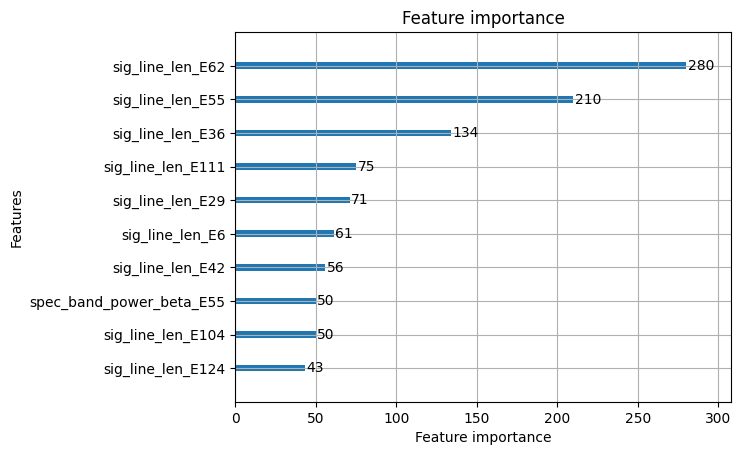

In [13]:
from lightgbm import plot_importance
plot_importance(clf, importance_type="split", max_num_features=10)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

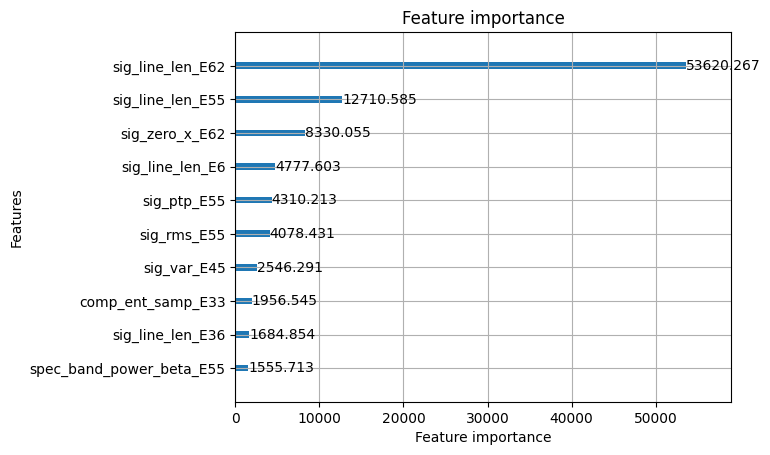

In [14]:
plot_importance(clf, importance_type="gain", max_num_features=10)

In [15]:
# Create dataloaders
train_loader = DataLoader(train_ds, batch_size=100, shuffle=True)
val_loader =  DataLoader(val_ds, batch_size=100, shuffle=True)

# Check labels

It is good practice to verify the labels and ensure the random seed is functioning correctly. If all labels are 'M' (male) or 'F' (female), it could indicate an issue with data loading or stratification, requiring further investigation.

In [16]:
# get the first batch to check the labels
dataiter = iter(train_loader)
first_item, label = dataiter.__next__()
np.array(label).T

array(['F', 'F', 'M', 'F', 'F', 'M', 'M', 'M', 'M', 'F', 'M', 'M', 'F',
       'M', 'M', 'M', 'F', 'M', 'M', 'M', 'M', 'M', 'M', 'F', 'F', 'M',
       'M', 'F', 'M', 'M', 'F', 'M', 'M', 'M', 'M', 'M', 'F', 'M', 'F',
       'F', 'M', 'M', 'F', 'F', 'M', 'M', 'F', 'M', 'M', 'F', 'M', 'F',
       'F', 'M', 'F', 'M', 'F', 'M', 'F', 'M', 'F', 'M', 'F', 'M', 'M',
       'F', 'F', 'F', 'M', 'M', 'M', 'F', 'F', 'F', 'M', 'F', 'M', 'M',
       'F', 'F', 'F', 'F', 'F', 'F', 'F', 'M', 'M', 'M', 'F', 'M', 'F',
       'F', 'M', 'F', 'F', 'F', 'F', 'F', 'F', 'M'], dtype='<U1')

# Create model

The model is a custom convolutional neural network with 24 input channels (EEG channels), 2 output classes (male vs. female), and an input window size of 256 samples (2 seconds of EEG data). See the reference below for more information.

[1] Truong, D., Milham, M., Makeig, S., & Delorme, A. (2021). Deep Convolutional Neural Network Applied to Electroencephalography: Raw Data vs Spectral Features. IEEE Engineering in Medicine and Biology Society. Annual International Conference, 2021, 1039–1042. https://doi.org/10.1109/EMBC46164.2021.9630708



In [17]:
# create model
from torchinfo import summary
from torch import nn

# MLP
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(features_ds.datasets[0].n_features, 100),
    nn.Linear(100, 100),
    nn.Linear(100, 100),
    nn.Linear(100, 2),
)

print(summary(model, input_size=first_item.shape))


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [100, 2]                  --
├─Flatten: 1-1                           [100, 1973]               --
├─Linear: 1-2                            [100, 100]                197,400
├─Linear: 1-3                            [100, 100]                10,100
├─Linear: 1-4                            [100, 100]                10,100
├─Linear: 1-5                            [100, 2]                  202
Total params: 217,802
Trainable params: 217,802
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 21.78
Input size (MB): 0.79
Forward/backward pass size (MB): 0.24
Params size (MB): 0.87
Estimated Total Size (MB): 1.90


# Model Training and Evaluation Process

This section trains the neural network using the Adamax optimizer, normalizes input data, computes cross-entropy loss, updates model parameters, and tracks accuracy across six epochs.

1. **Set Up Optimizer and Learning Rate Scheduler** – The `Adamax` optimizer initializes with a learning rate of 0.002 and weight decay of 0.001 for regularization.  

2. **Allocate Model to Device** – The model moves to the specified device (CPU, GPU, or MPS for Mac silicon) to optimize computation efficiency.  

3. **Normalize Input Data** – The `normalize_data` function standardizes input data by subtracting the mean and dividing by the standard deviation along the time dimension before transferring it to the appropriate device.  

4. **Train the Model for Two Epochs** – The training loop iterates through data batches with the model in training mode. It normalizes inputs, computes predictions, calculates cross-entropy loss, performs backpropagation, updates model parameters, and steps the learning rate scheduler. It tracks correct predictions to compute accuracy.  

5. **Evaluate on Test Data** – After each epoch, the model runs in evaluation mode on the test set. It computes predictions on normalized data and calculates test accuracy by comparing outputs with actual labels.  


In [18]:

from torch.nn import functional as F

optimizer = torch.optim.Adamax(model.parameters(), lr=0.0005, weight_decay=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
model.to(device=device)

# dictionary of genders for converting sample labels to numerical values
gender_dict = {'M': 0, 'F': 1}

epochs = 2
for e in range(epochs):
    
    # training
    correct_train = 0
    for t, (x, y) in enumerate(train_loader):
        model.train()  # put model to training mode
        scores = model(x)
        _, preds = scores.max(1)
        y = torch.tensor([gender_dict[gender] for gender in y], device=device, dtype=torch.long)
        correct_train += (preds == y).sum()/len(train_ds)

        # Calculates the cross-entropy loss and performs backpropagation
        loss = F.cross_entropy(scores, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if t % 50 == 0:
            print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
    
    # validation
    correct_test = 0
    for t, (x, y) in enumerate(val_loader):
        model.eval() # put model to testing mode
        scores = model(x)
        _, preds = scores.max(1)
        y = torch.tensor([gender_dict[gender] for gender in y], device=device, dtype=torch.long)
        correct_test += (preds == y).sum()/len(val_ds)

    print(f'Epoch {e}, Train accuracy: {correct_train:.2f}, Test accuracy: {correct_test:.2f}\n')


Epoch 0, Iteration 0, loss = 0.6878
Epoch 0, Iteration 50, loss = 0.2271
Epoch 0, Iteration 100, loss = 0.1683
Epoch 0, Iteration 150, loss = 0.1791
Epoch 0, Train accuracy: 0.90, Test accuracy: 0.73

Epoch 1, Iteration 0, loss = 0.1192
Epoch 1, Iteration 50, loss = 0.1162
Epoch 1, Iteration 100, loss = 0.1343
Epoch 1, Iteration 150, loss = 0.0558
Epoch 1, Train accuracy: 0.96, Test accuracy: 0.74

